# scikit-learn - Regression - 1
 >__Created__:  2018 Harrison B. Prosper
  

### Neural Networks
A neural network (NN) is a highly non-linear function. The functional form of a single layer NN with $I$ inputs and $J$ outputs is

$$y_{j}(x) = f\left(b_{j} + \sum_{i=1}^I w_{ji} \, x_i\right),\quad j = 1,\cdots,J,$$
which in matrix notation is
$$\mathbf{y} = f\left(\mathbf{b} + \mathbf{w} \, \mathbf{x}\right),$$
where $f(*)$ is a non-linear function to be applied *element-wise* to its matrix argument. Popular examples of $f(*)$ are
\begin{align*}
    f(z) & = \tanh{z},\\
    f(z) & = \max(0, z) \quad\textrm{reLU function}.
\end{align*}

Consider a neural network with $I$ inputs, $x_{i}, i = 1, \cdots, I$, a single hidden layer with $H$ nodes, and $K$ outputs $y_{k}(x), k = 1, \cdots, K$. Such a network is said to be *shallow* with structure $(I, H, K)$. The functional form is

$$y = g(\mathbf{b}_1 + \mathbf{w}_1 \, f(\mathbf{b}_0 + \mathbf{w}_0 \, \mathbf{x})),$$

where the subscripts label the layers, and, usually, the output function $g$ differs from $f$. For regression,  $g$ is
the $identity$. For 2-class (i.e., binary) classification it is usually the $logistic$ function 

$$g(z) = \frac{1}{1 + \exp(-z)},$$ 

while for multi-class classification one typically uses the $softwmax$ function

$$y_j = g(z_j) = \frac{\exp(z_j)}{\sum_{k=1}^K \exp(z_k)}.$$ 

For the special case of a single output network, $\mathbf{b}_1$ becomes a scalar $b$ and $\mathbf{w}_1$ 
is a column matrix.

### Deep Neural Networks
A feed forward deep neural network (DNN) contains two or more hidden layers 
compounded recursively. For example, a DNN with two hidden layers has the functional form

$$y = g(\mathbf{b}_2 + \mathbf{w}_2 \, f(\mathbf{b}_1 + \mathbf{w}_1 \, f(\mathbf{b}_0 + \mathbf{w}_0 \, \mathbf{x}))).$$

The matrices can be sparse or dense. Dense matrices yield fully-connected neural networks.

### Exercise
  1. Build a deep network, using __MLPRegression__, to predict wine quality. 
  1. Vary the number of layers and nodes/layer.

In [2]:
import os, sys
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.externals import joblib

import matplotlib as mp
import matplotlib.pyplot as plt
import pylab as pl

%matplotlib inline

In [3]:
# update fonts
FONTSIZE = 20
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}

mp.rc('font', **font)

### Load data into memory

In [4]:
wine  = pd.read_csv('../datasets/whitewine.csv')
inputs= wine.keys().tolist()[:-1]
wine[0:10]

,acetic,citric,suger,salt,SO2free,SO2tota,pH,sulfate,alcohol,quality
0,0.180,0.33,1.4,0.029,35.0,138.0,3.36,0.60,11.5,0.7
1,0.685,0.21,9.5,0.070,33.0,172.0,3.00,0.55,9.1,0.6
2,0.210,0.28,2.4,0.056,49.0,159.0,3.02,0.47,8.8,0.8
3,0.250,0.13,17.2,0.036,49.0,219.0,2.96,0.46,9.7,0.5
4,0.420,0.23,8.8,0.054,42.0,215.0,3.02,0.58,9.2,0.6
5,0.240,0.15,7.1,0.043,32.0,134.0,3.24,0.48,9.9,0.6
6,0.250,0.37,1.0,0.043,10.0,80.0,3.08,0.38,11.4,0.5
7,0.140,0.32,1.1,0.022,48.0,116.0,3.04,0.67,10.0,0.6
8,0.310,0.26,7.3,0.050,37.0,157.0,3.09,0.43,9.0,0.5
9,0.410,0.18,3.5,0.027,23.0,109.0,3.34,0.54,12.8,0.8


### Plot wine quality distribution

In [5]:
def plotVariable(df, name, x_label, x_range=(0.05, 1.05), 
                 nbins=10, kolor='blue', fgsize=(12, 6)):
    # set size of figure
    plt.figure(figsize=fgsize)
    c, b, _ = plt.hist(df[name],
                       bins=nbins, 
                       color=kolor,
                       alpha=0.3,
                       log=False,
                       range=x_range, 
                       normed=True)

    plt.xlim([0, 1])
    plt.ylim([0, 5])
    plt.xlabel(x_label)
    plt.savefig("scitkit-learn_wine_%s.png" % name)
    plt.show()
    
    # get mid-point of each of n bins
    # b[1:] = b[1], b[2],..., b[n]
    # b[:-1]= b[0], b[1],..., b[n-1]
    m = (b[1:] + b[:-1]) / 2
    return (c, m)

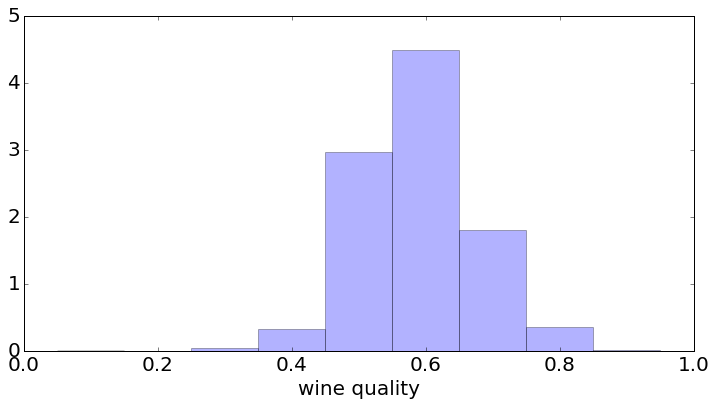

In [6]:
c, m = plotVariable(wine, 'quality', 'wine quality')

We see that the data are very unbalanced. Therefore, we should expect some difficulty in building a good wine quality predictor, even assuming that we have the correct input variables.

In [7]:
def plotVariables(wine, variables, fgsize=(10, 10)):
    cmap = plt.cm.rainbow
    norm = mp.colors.Normalize(vmin=min(wine.quality), 
                               vmax=max(wine.quality))
    

    pd.scatter_matrix(wine[variables], 
                      c=cmap(norm(wine.quality)),
                      alpha=0.9,
                      marker='o',
                      figsize=fgsize)
    plt.savefig("scikit-learn_wine_variables.png")
    plt.show()

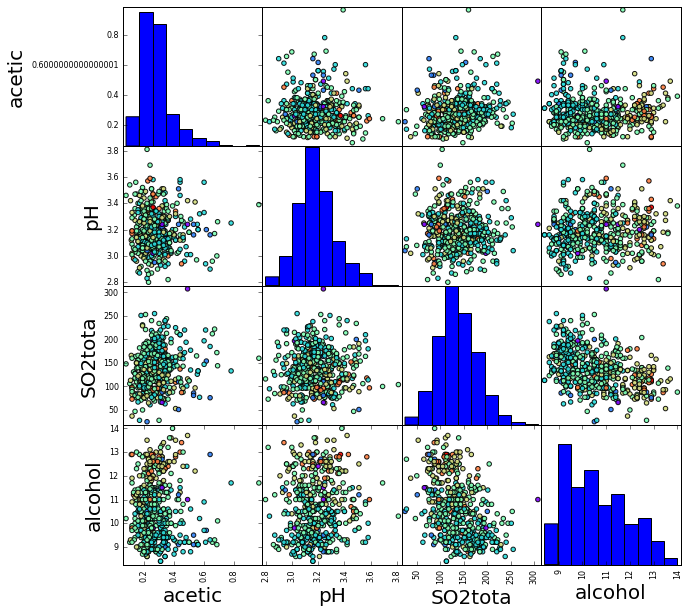

In [8]:
plotVariables(wine[:500], 
              variables=['acetic', 'pH', 'SO2tota', 'alcohol'], 
              fgsize=(10, 10))

### Train, validation, and test sets
There is some confusion in terminology regarding validation and test samples (or sets). We shall adhere to these defintions (see https://machinelearningmastery.com/difference-test-validation-datasets/):
   
  * __Training Dataset__: The sample of data used to fit the model.
  * __Validation Dataset__: The sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. The evaluation becomes more biased as skill on the validation dataset is incorporated into the model configuration.
  * __Test Dataset__: The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

The validation set will be some small fraction of the training set and will be used to decide when to stop the training.

In [9]:
test_fraction  = 0.16
train_data, test_data = train_test_split(wine, test_size=test_fraction)

print('train set size:      %4d' % train_data.shape[0])
print('test set size:       %4d' % test_data.shape[0])

train set size:      4114
test set size:        784


### Prepare data for training/validation/testing

In [10]:
def standardize_data(train_data, test_data, names):
    scaler  = StandardScaler()
    scaler.fit(train_data[names])
    
    train_x = scaler.transform(train_data[names])
    train_y = np.array(train_data['quality'])
    
    test_x  = scaler.transform(test_data[names])
    test_y  = np.array(test_data['quality'])
    return (train_x, test_x, train_y, test_y, scaler)

In [11]:
train_x, test_x, train_y, test_y, scaler = standardize_data(train_data, 
                                                            test_data, 
                                                            inputs)

### Define function space 
A particular choice of neural network architecture, be it deep, convolutional, recurrent, etc., defines the space of possible functions that can be accessed via training. If you get poor results, it could be because you have insufficient training data, or perhaps your function space does not contain a function that is a good approximation to the desired function, or it could be that your training algorithm is unable to locate the desired function within your function space, or any combination of these.

In [12]:
# Stop training when validation score is not improving. 
dnn = MLPRegressor(hidden_layer_sizes=(20, 10), 
                    max_iter=500, 
                    alpha=1e-2,
                    solver='adam',
                    activation='relu',
                    verbose=1, 
                    tol=1e-12, 
                    warm_start=False,
                    random_state=1)

### Choose a function, aka train a regressor!

In [13]:
print "*** TRAINING ***"
dnn.fit(train_x, train_y)
       
print
print("Training set score: %10.4f" % dnn.score(train_x, train_y))      
print("Test set score:     %10.4f" % dnn.score(test_x,  test_y))

filename = 'scikit-learn_wine_dnn.pkl'
print "save to %s" % filename
joblib.dump(dnn, filename)

*** TRAINING ***
Iteration 1, loss = 0.31460334
Iteration 2, loss = 0.15555500
Iteration 3, loss = 0.08719450
Iteration 4, loss = 0.06162149
Iteration 5, loss = 0.04994581
Iteration 6, loss = 0.04253449
Iteration 7, loss = 0.03689896
Iteration 8, loss = 0.03225446
Iteration 9, loss = 0.02830453
Iteration 10, loss = 0.02493566
Iteration 11, loss = 0.02205538
Iteration 12, loss = 0.01965155
Iteration 13, loss = 0.01757967
Iteration 14, loss = 0.01580964
Iteration 15, loss = 0.01435948
Iteration 16, loss = 0.01314619
Iteration 17, loss = 0.01206463
Iteration 18, loss = 0.01119241
Iteration 19, loss = 0.01047372
Iteration 20, loss = 0.00984063
Iteration 21, loss = 0.00925555
Iteration 22, loss = 0.00881089
Iteration 23, loss = 0.00837197
Iteration 24, loss = 0.00800070
Iteration 25, loss = 0.00767818
Iteration 26, loss = 0.00738360
Iteration 27, loss = 0.00712074
Iteration 28, loss = 0.00685877
Iteration 29, loss = 0.00663203
Iteration 30, loss = 0.00643430
Iteration 31, loss = 0.00624444


['scikit-learn_wine_dnn.pkl']

### Plot loss curve vs. epochs

In [22]:
def plotLoss(dnn, ftsize=FONTSIZE):
    y    = dnn.loss_curve_
    x    = np.array(range(len(y)))+1

    ymin = 0.0
    ymax = 0.2
    epoch= range(len(y))
    xmin = 0
    xmax = len(x)
    
    # set size of figure
    plt.figure(figsize=(8,4));

    # get axis info
    axes = plt.gca()
    # set axes' limits
    axes.set_xlim(xmin, xmax)
    axes.set_ylim(ymin, ymax)
    
    # annotate axes
    plt.xlabel(r'epoch', fontsize=ftsize)
    plt.ylabel(r'loss',  fontsize=ftsize)
    
    # choose color of points
    plt.plot(x, y, 'b-')
    plt.savefig('scikit-learn_wine_dnn_loss.png')
    plt.show()

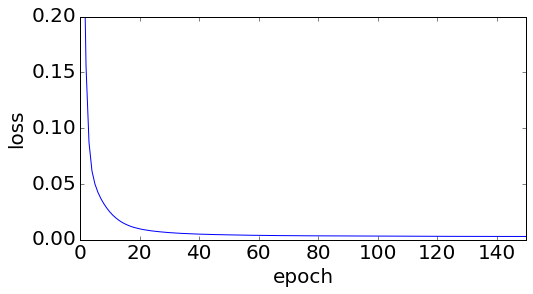

In [23]:
plotLoss(dnn)

### plot results

In [24]:
def plotResults(dnn, test_x, test_y, 
                xmin=0.35, xmax=0.95, 
                ymin=0.35, ymax=0.95,
                step=0.10,
                ftsize=FONTSIZE):
    
    p = dnn.predict(test_x)
    m = np.arange(xmin, xmax, step)
    
    # set size of figure
    plt.figure(figsize=(10, 8))
    
    counts,ybins,xbins,image = plt.hist2d(test_y, p, bins=(m, m))
    plt.colorbar()
    
    min_count = np.min(counts)
    max_count = np.max(counts)
    mylevels  = np.arange(min_count, max_count, 5)
    
    plt.contour(counts,
                extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],
                linewidths=2,
                levels=mylevels)
    
    plt.plot([0,1], [0,1], c='white', lw=3, linestyle='--')
    
    # annotate axes
    plt.xlabel(r'wine quality', fontsize=ftsize)
    plt.ylabel(r'predicted wine quality', fontsize=ftsize)
    plt.xlim([xmin, xmax-step])
    plt.ylim([ymin, ymax-step])
    plt.savefig('scikit-learn_wine_dnn_results.png')
    plt.show()

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


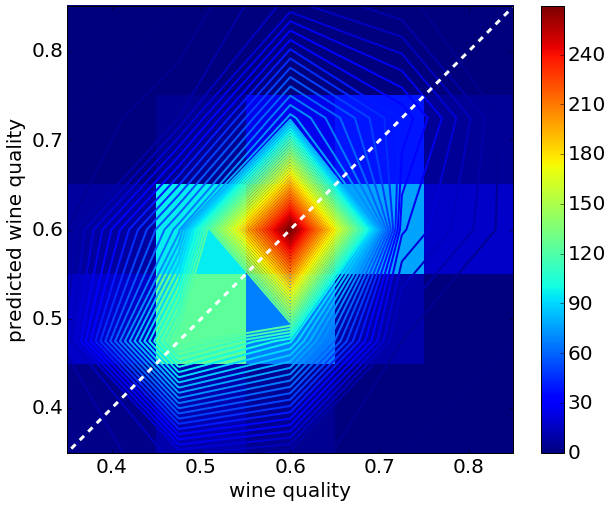

In [26]:
plotResults(dnn, test_x, test_y)